# ****INTRODUCTION****

This project is to forecast sales for Walmart superstore using time series analytics by going through industry best practice to deal with time series problems. The process includes:
- Check stationarity
- Transform data
- Decompose data into components
- Detect anomalies
- Test white noise
- Identify orders for model components
- Build models and measure their performance.

Use case: To forecast sales for a particular product category of Walmart.  

**0. IMPORTING LIBRARIES**

In [211]:
#pip install xlrd
#pip install tqdm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
register_matplotlib_converters()
from time import time
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm.notebook import tqdm_notebook

**I. READING THE DATA**

In [2]:
df=pd.read_excel('US_Superstore_data.xls')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


**II. DATA CLEANING**

****a. Data dimension****

In [3]:
df.shape

(9994, 21)

****b. Data exploration****

- Check on variables

- Type of data

In [4]:
df.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

There are no missing values. 

- Count of unique values

In [5]:
df.nunique()

Row ID           9994
Order ID         5009
Order Date       1237
Ship Date        1334
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              531
State              49
Postal Code       631
Region              4
Product ID       1862
Category            3
Sub-Category       17
Product Name     1850
Sales            6144
Quantity           14
Discount           12
Profit           7545
dtype: int64

**Row ID** has all unique values, while **Country** has only 1 value -> Need to drop.

In [6]:
#Dropping
df=df.drop(['Row ID', 'Country'],axis=1)

****c. Missing data****

In [7]:
df.isnull().sum()

Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

****d. Duplicated Data****

In [8]:
df.duplicated().sum()

1

There is one row with duplicated values, then we should remove it too.

In [9]:
# Remove duplicated data
df = df.drop_duplicates(keep="first")

****e. Feature selection: Drop unnnecessary columns****

As the purpose of this project is to predict sales, we only keep fundamental variables for the predictions such as timestamp, category, subcategory, sales, quantity and profit only. The rest will be removed.

In [10]:
#Dropping
df=df[['Order Date','Product Name', "Category","Sub-Category","Sales","Quantity","Profit"]]
df.head()

,Order Date,Product Name,Category,Sub-Category,Sales,Quantity,Profit
0,2016-11-08,Bush Somerset Collection Bookcase,Furniture,Bookcases,261.9600,2,41.9136
1,2016-11-08,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs,731.9400,3,219.5820
2,2016-06-12,Self-Adhesive Address Labels for Typewriters b...,Office Supplies,Labels,14.6200,2,6.8714
3,2015-10-11,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables,957.5775,5,-383.0310
4,2015-10-11,Eldon Fold 'N Roll Cart System,Office Supplies,Storage,22.3680,2,2.5164


**III. ANALYSIS**

****a. Check statistic of numerical data****

In [11]:
df.describe()

,Sales,Quantity,Profit
count,9993.000000,9993.000000,9993.000000
mean,229.852846,3.789753,28.660971
std,623.276074,2.225149,234.271476
min,0.444000,1.000000,-6599.978000
25%,17.280000,2.000000,1.731000
50%,54.480000,3.000000,8.671000
75%,209.940000,5.000000,29.364000
max,22638.480000,14.000000,8399.976000


- The highest order quantity is 14 per product.
- Some products have negative profit.
- The smallest product sales is 0.444$.

****b. Check on level of categorical data****

- **Category**

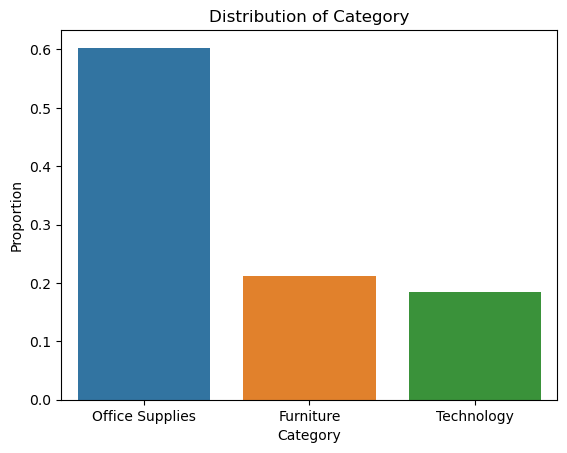

In [12]:
# Get the value counts of each category
category_counts = df['Category'].value_counts(normalize=True)

# Create a color palette using the default palette in Seaborn
num_categories = len(category_counts)
color_palette = sns.color_palette(n_colors=num_categories)

# Create a bar plot with the color palette
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette=color_palette)

# Set the title and labels for the plot
ax.set_title('Distribution of Category')
ax.set_xlabel('Category')
ax.set_ylabel('Proportion')

plt.show()

- **Sub-Category**

In [13]:
#number of products in each sub-category
df['Sub-Category'].value_counts()

Binders        1523
Paper          1370
Furnishings     957
Phones          889
Storage         846
Art             796
Accessories     775
Chairs          616
Appliances      466
Labels          364
Tables          319
Envelopes       254
Bookcases       228
Fasteners       217
Supplies        190
Machines        115
Copiers          68
Name: Sub-Category, dtype: int64

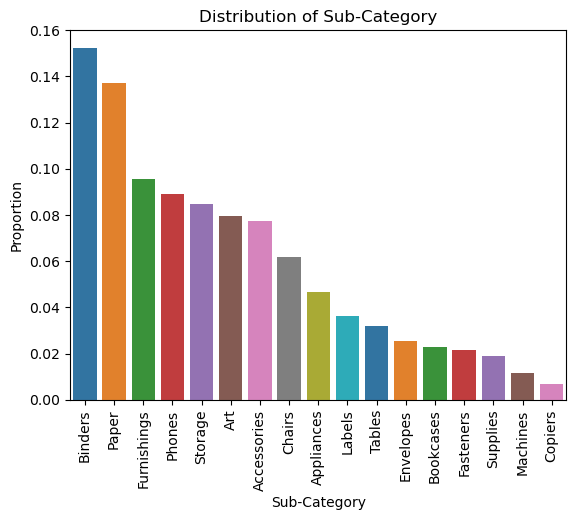

In [14]:
# Get the value counts of each sub-category
Sub_cat_count = df['Sub-Category'].value_counts(normalize=True)

# Create a color palette using the default palette in Seaborn
num_sub_cat = len(Sub_cat_count)
color_palette = sns.color_palette(n_colors=num_sub_cat)

# Create a bar plot with the color palette
ax = sns.barplot(x=Sub_cat_count.index, y=Sub_cat_count.values, palette=color_palette)

# Set the title and labels for the plot
ax.set_title('Distribution of Sub-Category')
ax.set_xlabel('Sub-Category')
ax.set_ylabel('Proportion')
plt.xticks(rotation=90)
plt.show()

**c. Sales Analysis**

- **By category**

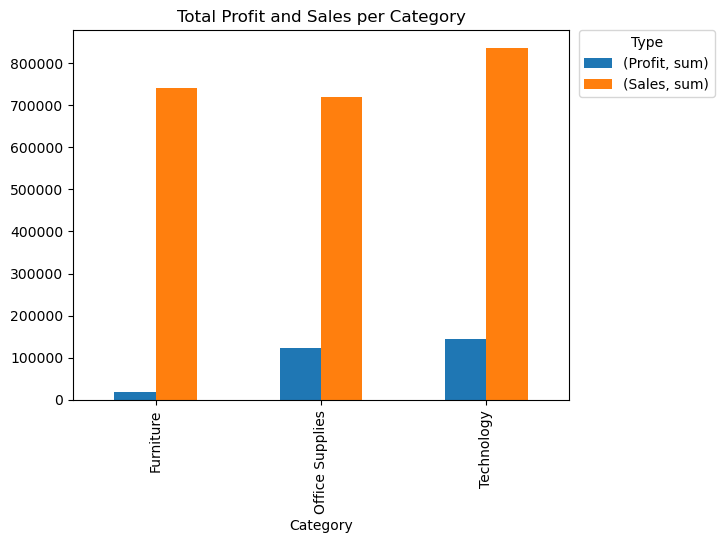

In [15]:
df.groupby('Category')['Profit','Sales'].agg(['sum']).plot.bar()
plt.title('Total Profit and Sales per Category')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Type')
plt.show()

Highest profit is earned by Technology category since Selling price for items belonging to this category must be high compared to other products.
Office Supplies seems to have the highest profit margin among all categories.

In [16]:
#number of products available in store
df['Product Name'].nunique()

1850

In [17]:
df['Product Name'].value_counts()

Staple envelope                                                                        48
Staples                                                                                46
Easy-staple paper                                                                      46
Avery Non-Stick Binders                                                                20
Staples in misc. colors                                                                19
                                                                                       ..
Boston 1900 Electric Pencil Sharpener                                                   1
RCA ViSYS 25423RE1 Corded phone                                                         1
Canon Color ImageCLASS MF8580Cdw Wireless Laser All-In-One Printer, Copier, Scanner     1
Newell 342                                                                              1
Eldon Jumbo ProFile Portable File Boxes Graphite/Black                                  1
Name: Prod

There are a total of 1850 distinct products, in which the top selling one is Staple envelope. 

- **Profit Margin**

In order to investigate the margin, the author creates a new column.

In [18]:
df['Profit_Margin']=round((df['Profit']/df['Sales'])*100,2)

In [19]:
#Profit Percentage of first 5 product names
df.loc[0:4,['Product Name','Profit_Margin']]

,Product Name,Profit_Margin
0,Bush Somerset Collection Bookcase,16.00
1,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",30.00
2,Self-Adhesive Address Labels for Typewriters b...,47.00
3,Bretford CR4500 Series Slim Rectangular Table,-40.00
4,Eldon Fold 'N Roll Cart System,11.25


**Top products with highest profit:**

In [20]:
df.groupby(['Product Name']).Profit_Margin.mean().sort_values(ascending=False).head(10)

Product Name
Southworth Structures Collection                                                         50.0
Xerox 1890                                                                               50.0
Tops Green Bar Computer Printout Paper                                                   50.0
Canon imageCLASS MF7460 Monochrome Digital Laser Multifunction Copier                    50.0
Adams Telephone Message Book w/Frequently-Called Numbers Space, 400 Messages per Book    50.0
Avery 475                                                                                50.0
Xerox 1983                                                                               49.0
Strathmore #10 Envelopes, Ultimate White                                                 49.0
Xerox 193                                                                                49.0
Ativa V4110MDD Micro-Cut Shredder                                                        49.0
Name: Profit_Margin, dtype: float64

****d. Outliers / Anomalies****

- **Check on descriptive analysis of continuous variables**

In [21]:
df.describe()

,Sales,Quantity,Profit,Profit_Margin
count,9993.000000,9993.000000,9993.000000,9993.000000
mean,229.852846,3.789753,28.660971,12.033023
std,623.276074,2.225149,234.271476,46.677486
min,0.444000,1.000000,-6599.978000,-275.000000
25%,17.280000,2.000000,1.731000,7.500000
50%,54.480000,3.000000,8.671000,27.000000
75%,209.940000,5.000000,29.364000,36.250000
max,22638.480000,14.000000,8399.976000,50.000000


- **Dig deep in details**

****Sales****

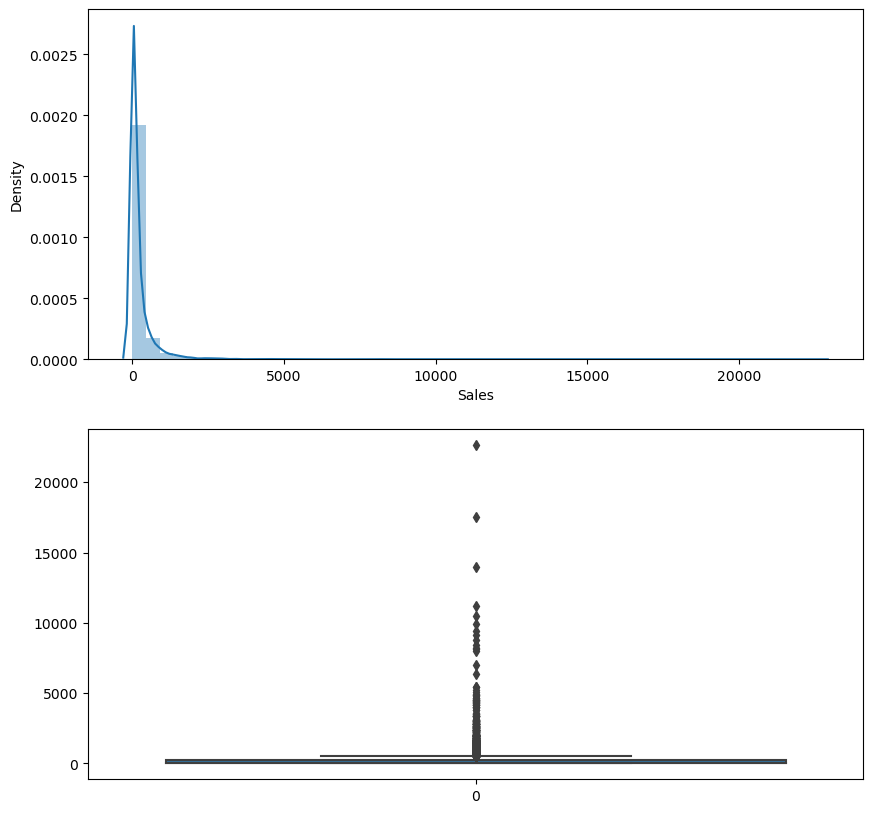

In [22]:
# Creating plot
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.distplot(df['Sales'])
plt.subplot(2,1,2)
sns.boxplot(df['Sales'])
# show plot
plt.show()

Investigate rows in 99 percentiles up.

In [23]:
df[df["Sales"] > df["Sales"].quantile(0.999)].sort_values("Sales", ascending = False)

,Order Date,Product Name,Category,Sub-Category,Sales,Quantity,Profit,Profit_Margin
2697,2014-03-18,Cisco TelePresence System EX90 Videoconferenci...,Technology,Machines,22638.480,6,-1811.0784,-8.00
6826,2016-10-02,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,17499.950,5,8399.9760,48.00
8153,2017-03-23,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,13999.960,4,6719.9808,48.00
2623,2017-10-22,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,11199.968,4,3919.9888,35.00
4190,2017-11-17,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,10499.970,3,5039.9856,48.00
9039,2016-12-17,GBC Ibimaster 500 Manual ProClick Binding System,Office Supplies,Binders,9892.740,13,4946.3700,50.00
4098,2014-09-23,Ibico EPK-21 Electric Binding System,Office Supplies,Binders,9449.950,5,4630.4755,49.00
4277,2016-04-16,"3D Systems Cube Printer, 2nd Generation, Magenta",Technology,Machines,9099.930,7,2365.9818,26.00
8488,2016-02-02,HP Designjet T520 Inkjet Large Format Printer ...,Technology,Machines,8749.950,5,2799.9840,32.00
6425,2016-05-23,Canon imageCLASS 2200 Advanced Copier,Technology,Copiers,8399.976,4,1119.9968,13.33


Well, the order with maximum values of 22,680.48$ is from a Machine purchase, so that it might not be an outlier. The same could be applied for the rest. Thus the author decides to keep all data without removing them.

**IV. TIME-SERIES ANALYSIS**

To analyze for the time series data, we have to answer 2 critical questions:
- Which **time intervals** we should use to predict as time series require time stamps to be equally spaced.
- Which **objects** we should work with, such as "Category sales", "Sub Category sales", "Product sales", or perhaps "Product unit".


**a. Timestamp analysis**

- **Order by date**

In [235]:
df['Order Date'].value_counts()

2016-09-05    38
2017-09-02    36
2016-11-10    35
2017-12-01    34
2017-12-02    34
              ..
2016-02-25     1
2016-10-25     1
2014-02-21     1
2016-10-18     1
2014-01-21     1
Name: Order Date, Length: 1237, dtype: int64

It really depends on dates, in which the purchase frequency is different for days.

- **Time interval**

In [24]:
print("Latest time frame: " ,max(df['Order Date']))
print("Earliest time frame: " ,min(df['Order Date']))

Latest time frame:  2017-12-30 00:00:00
Earliest time frame:  2014-01-03 00:00:00


In [25]:
# Compute time intervals between consecutive dates
time_diff = df['Order Date'].diff()

# Check if all time intervals are the same
if all(time_diff == time_diff[0]):
    print("Data is equally spaced.")
else:
    print("Data is not equally spaced.")

Data is not equally spaced.


**Conclusion:** Since time interval is not equal, we should aggregate data in month and reinvestigate them.

**b. Objects of prediction**

***Sales by Category through years***

In [27]:
# Aggregate data
by_category = df.groupby(['Category','Order Date']).sum("Sales").reset_index()
by_category

,Category,Order Date,Sales,Quantity,Profit,Profit_Margin
0,Furniture,2014-01-06,2573.820,9,746.4078,29.00
1,Furniture,2014-01-07,76.728,3,-53.7096,-70.00
2,Furniture,2014-01-10,51.940,1,21.2954,41.00
3,Furniture,2014-01-11,9.940,2,3.0814,31.00
4,Furniture,2014-01-13,879.939,9,91.2798,17.18
...,...,...,...,...,...,...
2856,Technology,2017-12-25,401.208,14,71.7174,89.25
2857,Technology,2017-12-27,164.388,2,-35.6174,-21.67
2858,Technology,2017-12-28,14.850,3,4.0095,27.00
2859,Technology,2017-12-29,302.376,3,22.6782,7.50


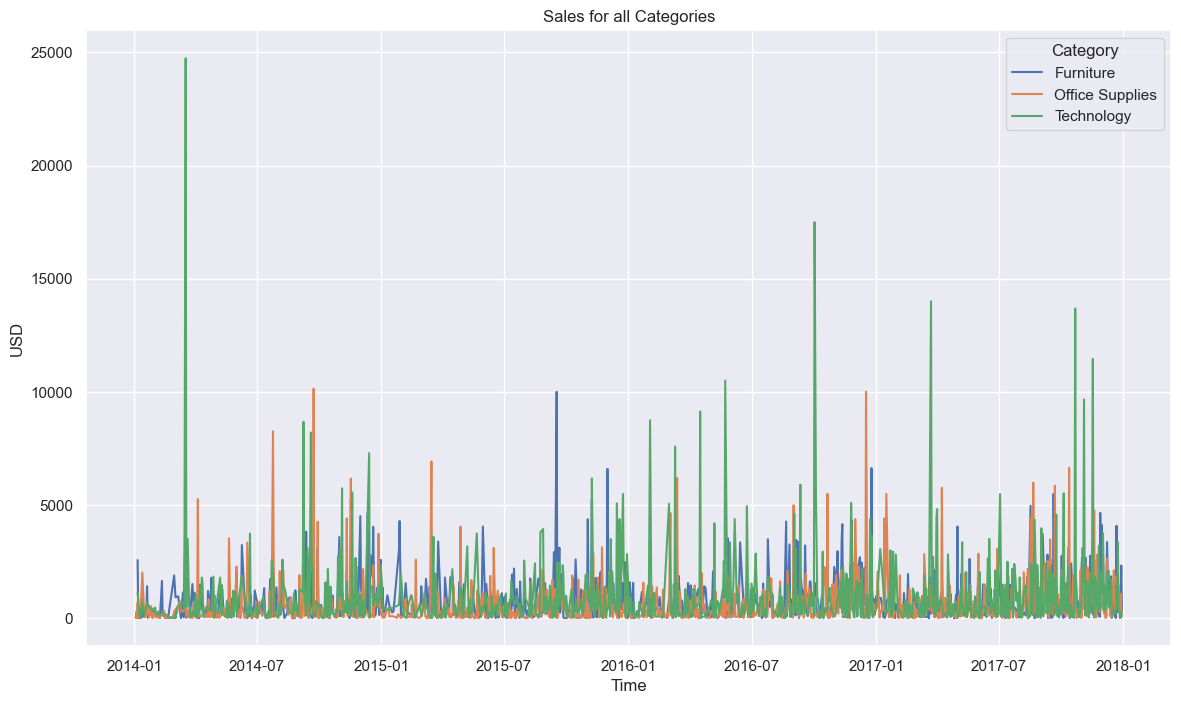

In [239]:
# Plot
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=by_category, x ='Order Date', y = 'Sales',
                  hue='Category',legend='full')
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Sales for all Categories')
plt.show()

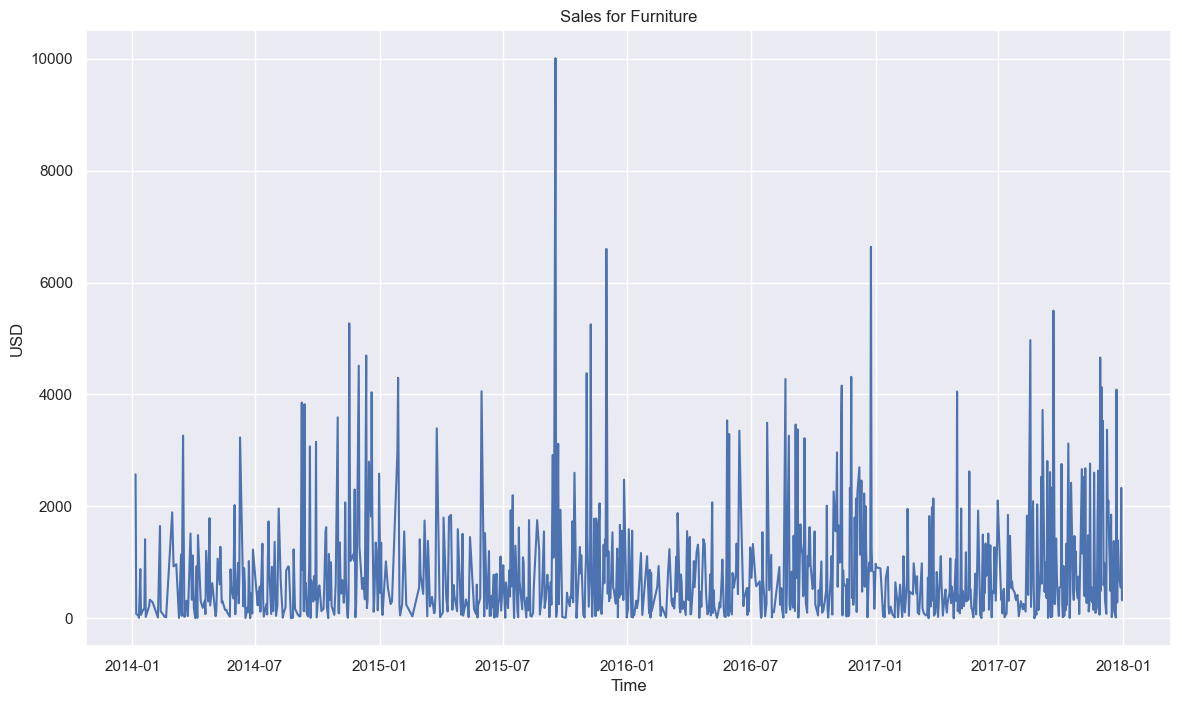

In [28]:
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=by_category[by_category["Category"]=="Furniture"], x ='Order Date', y = 'Sales')
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Sales for Furniture')
plt.show()

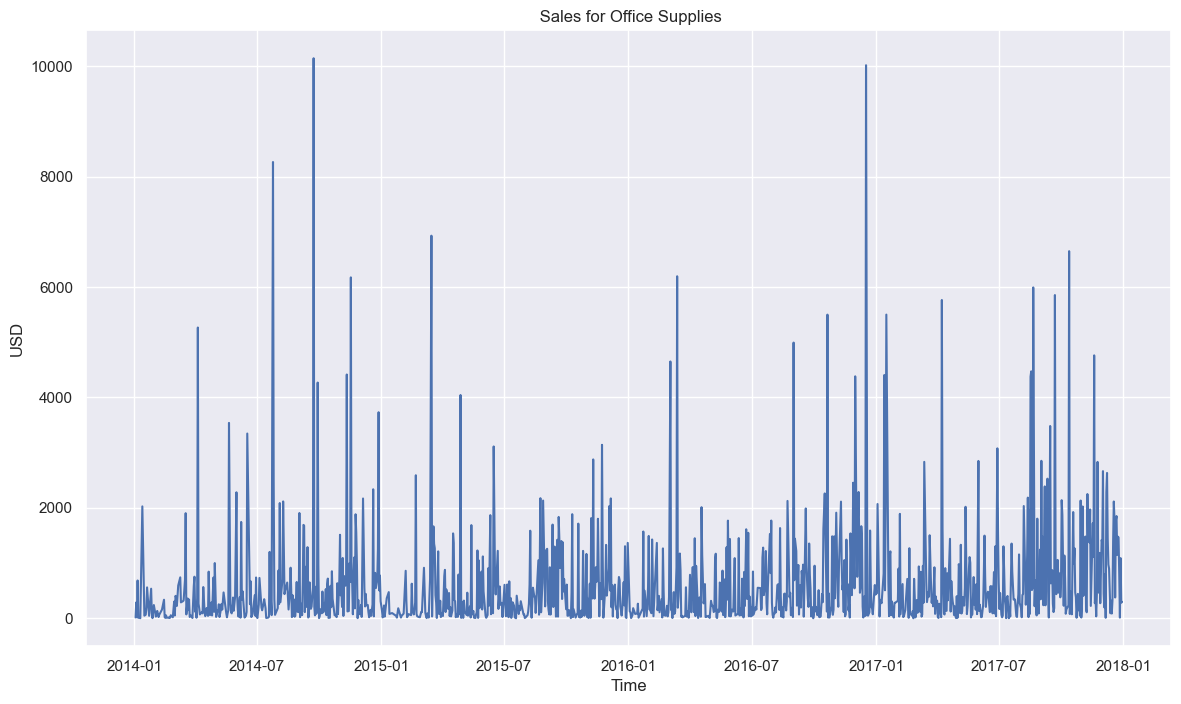

In [29]:
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=by_category[by_category["Category"]=="Office Supplies"], x ='Order Date', y = 'Sales')
plt.ylabel('USD')
plt.xlabel('Time')
plt.title(' Sales for Office Supplies')
plt.show()

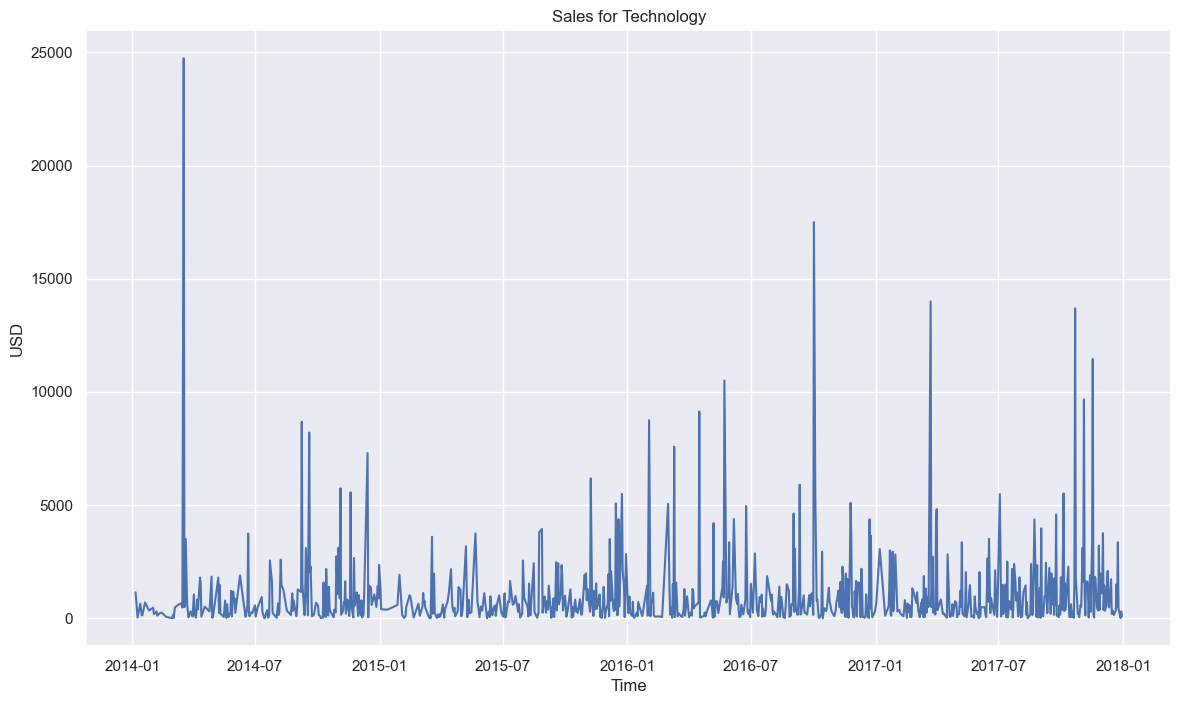

In [30]:
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=by_category[by_category["Category"]=="Technology"], x ='Order Date', y = 'Sales')
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Sales for Technology')
plt.show()

***Sales by product through years***

In [31]:
# Aggregate data
by_product = df.groupby(['Product Name','Order Date']).sum("Sales").reset_index()
by_product

,Product Name,Order Date,Sales,Quantity,Profit,Profit_Margin
0,"""While you Were Out"" Message Book, One Form pe...",2017-09-03,8.904,3,3.3390,37.5
1,"""While you Were Out"" Message Book, One Form pe...",2017-10-30,7.420,2,3.7100,50.0
2,"""While you Were Out"" Message Book, One Form pe...",2017-11-13,8.904,3,3.3390,37.5
3,"#10 Gummed Flap White Envelopes, 100/Box",2015-11-03,6.608,2,2.1476,32.5
4,"#10 Gummed Flap White Envelopes, 100/Box",2016-01-15,16.520,4,7.5992,46.0
...,...,...,...,...,...,...
9948,netTALK DUO VoIP Telephone Service,2014-12-05,167.968,4,62.9880,37.5
9949,netTALK DUO VoIP Telephone Service,2015-06-20,125.976,3,47.2410,37.5
9950,netTALK DUO VoIP Telephone Service,2015-09-25,104.980,2,52.4900,50.0
9951,netTALK DUO VoIP Telephone Service,2016-01-09,377.928,9,141.7230,37.5


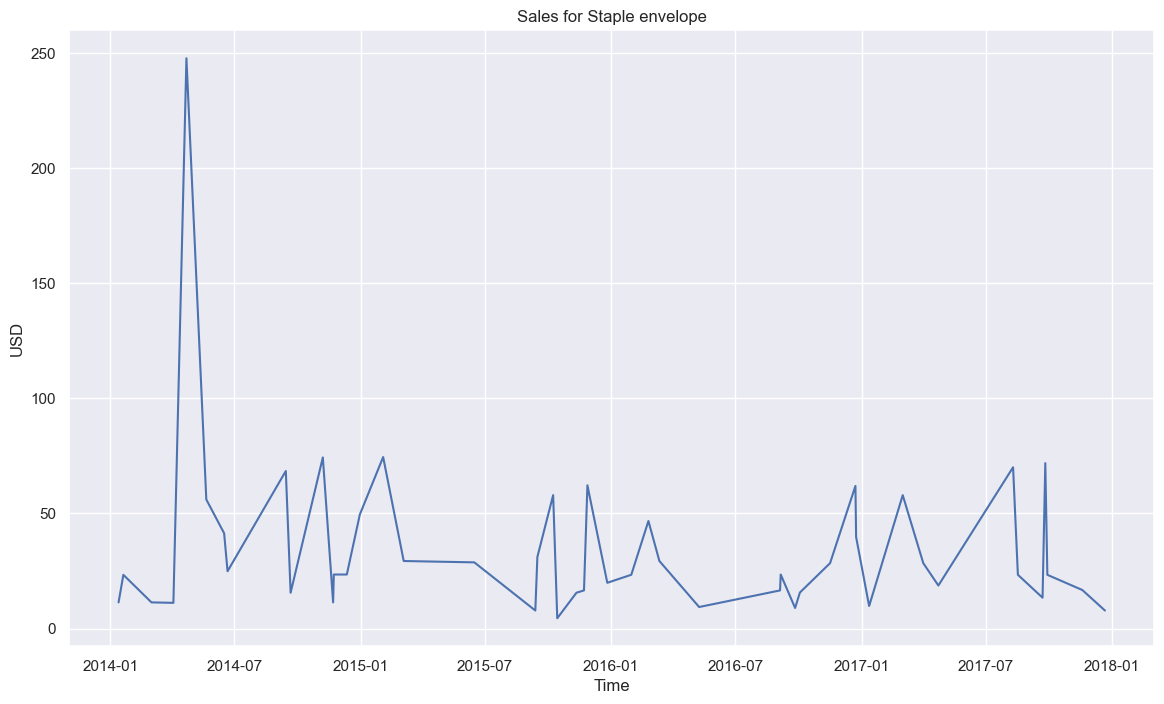

In [32]:
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=by_product[by_product["Product Name"]=="Staple envelope"], x ='Order Date', y = 'Sales')
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Sales for Staple envelope')
plt.show()

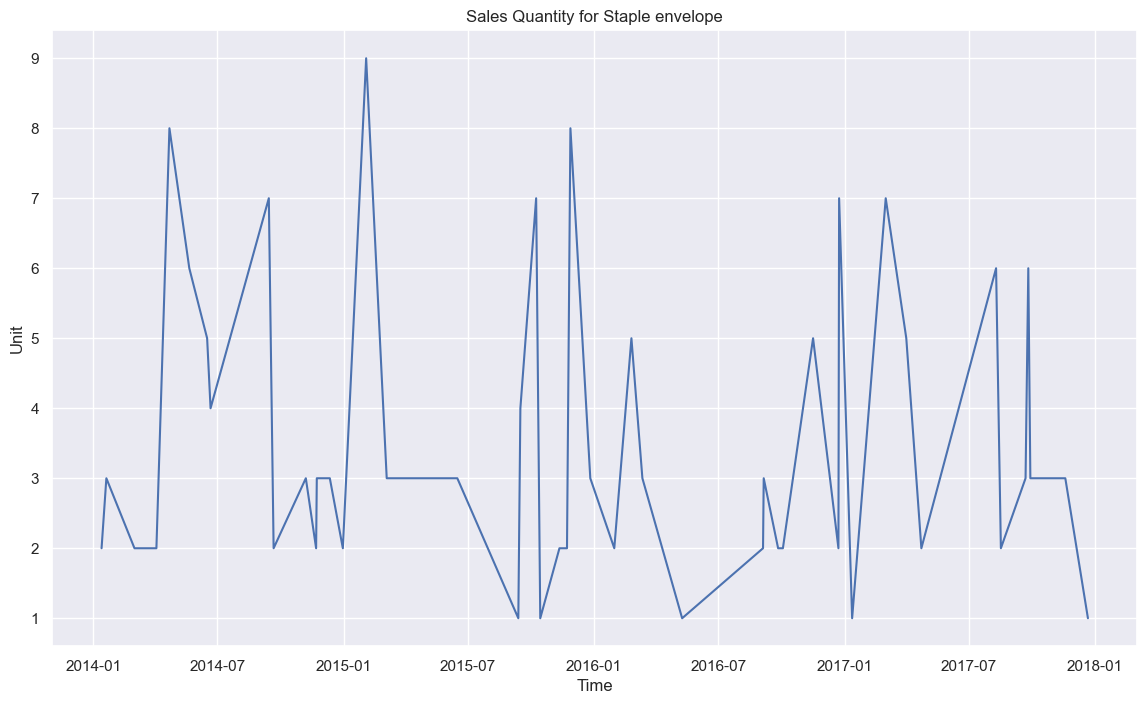

In [33]:
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=by_product[by_product["Product Name"]=="Staple envelope"], x ='Order Date', y = 'Quantity')
plt.ylabel('Unit')
plt.xlabel('Time')
plt.title('Sales Quantity for Staple envelope')
plt.show()

**Conclusion**: After checking, the author will decide to work with:

- Time interval of **months**
- Object: sales for **Office supplies category** as this category may expose seasonal pattern for the predictions.

**V. MODELING**

***A. DATA TRANSFORMATION***

**a. Transforming Data for Time series**

In [34]:
# Filter Office Supplies and retain only Order Date and Sales
df_new = by_category[by_category["Category"]=="Office Supplies"][['Order Date', 'Sales']]
# Convert Order Date to datetime dtype
df_new['Order Date'] = pd.to_datetime(df_new['Order Date'])
# Group by month
df_new = df_new.groupby(pd.Grouper(key='Order Date', freq='MS')).sum().reset_index()
# Display
df_new.head(5)

,Order Date,Sales
0,2014-01-01,4851.080
1,2014-02-01,1071.724
2,2014-03-01,8605.879
3,2014-04-01,11155.074
4,2014-05-01,7135.624


In [35]:
df_new.dtypes

Order Date    datetime64[ns]
Sales                float64
dtype: object

Data is in correct format.

**b. Time Interval check**

In [36]:
# Compute time intervals between consecutive dates
time_diff1 = df_new['Order Date'].diff()
time_diff1.value_counts()

31 days    27
30 days    16
28 days     3
29 days     1
Name: Order Date, dtype: int64

As we can see, data is grouped equally by month. Therefore, we are ready to work further.

**c. Plot data**

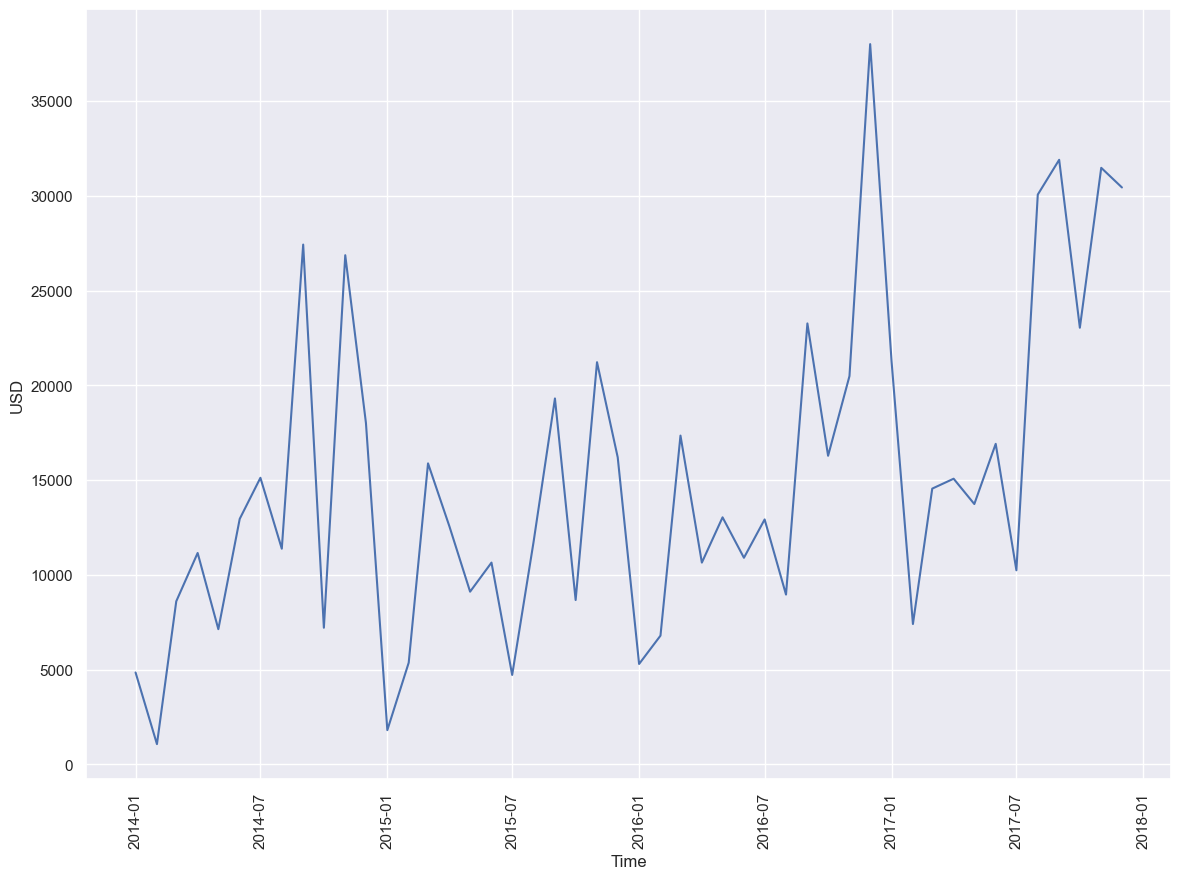

In [249]:
sns.set(rc={'figure.figsize':(14,10)})
ax = sns.lineplot(data=df_new, x ='Order Date', y = 'Sales')
plt.ylabel('USD')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.show()

***B. MODELING TIME SERIES DATA***

**Step 1: Check STATIONARITY and TRANSFORMATION if any**

In [37]:
def generate_ar_process(lags, coefs, length):
    
    #cast coefs to np array
    coefs = np.array(coefs)
    
    #initial values
    series = [np.random.normal() for _ in range(lags)]
    
    for _ in range(length):
        #get previous values of the series, reversed
        prev_vals = series[-lags:][::-1]
        
        #get new value of time series
        new_val = np.sum(np.array(prev_vals) * coefs) + np.random.normal()
        
        series.append(new_val)
        
    return np.array(series)

In [38]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [39]:
perform_adf_test(df_new['Sales'])

ADF Statistic: -1.905481
p-value: 0.329487


The time series is **not stationary**. As a result, we need to transform data before moving to next parts. The technique that author would use is differencing.

**First differencing**

In [40]:
# Create a new column of differenced sales
df_new['diff_Sales'] = df_new['Sales'].diff()
# Drop missing values
df_new = df_new.dropna()

In [41]:
df_new.tail()

,Order Date,Sales,diff_Sales
43,2017-08-01,30059.852,19818.384
44,2017-09-01,31895.843,1835.991
45,2017-10-01,23037.192,-8858.651
46,2017-11-01,31472.337,8435.145
47,2017-12-01,30436.942,-1035.395


We test stationarity again for our first differencing data.

In [42]:
# Test stattionarity again for new data
perform_adf_test(df_new['diff_Sales'])

ADF Statistic: -4.308890
p-value: 0.000429


The data now is **stationary**. And this would be the data we work with in next steps.

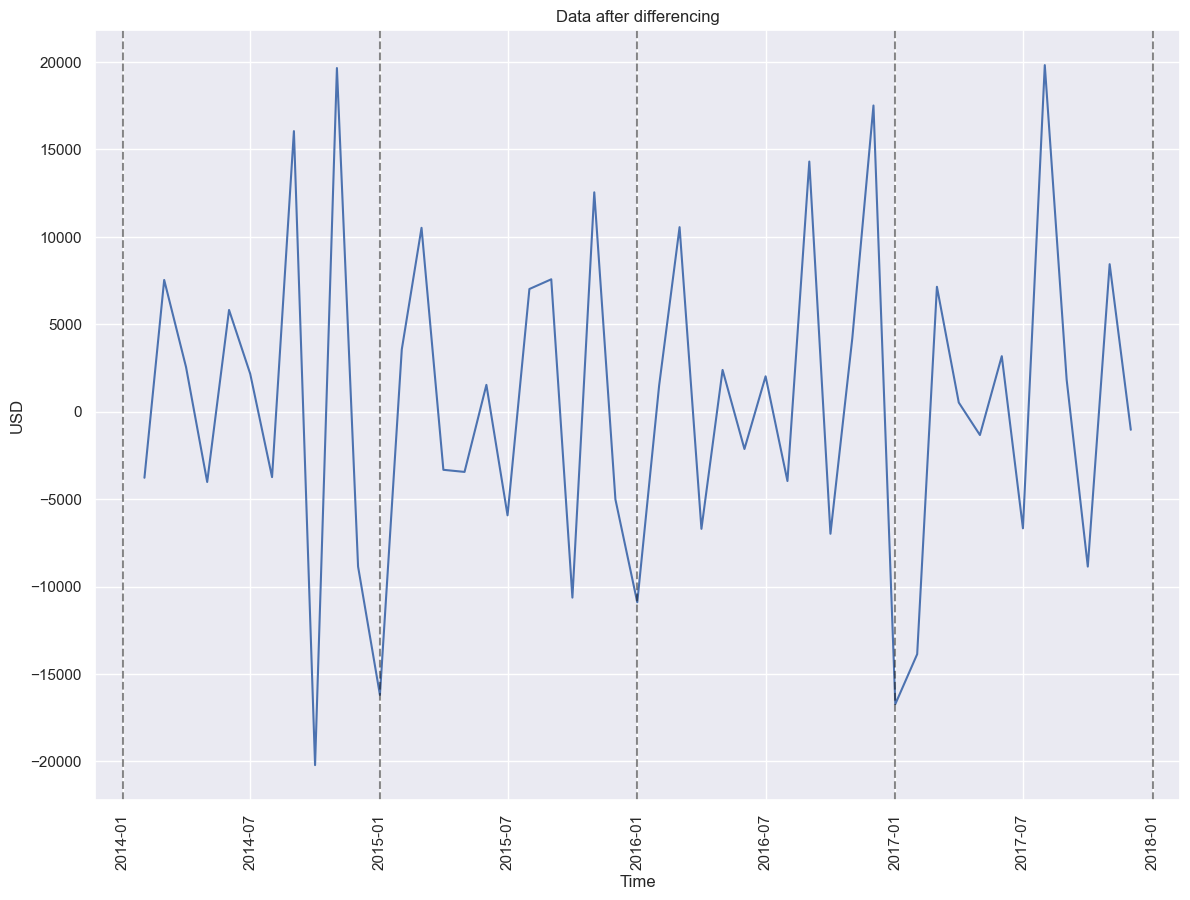

In [256]:
# Plot to see data again
sns.lineplot(data=df_new, x ='Order Date', y = 'diff_Sales')
plt.ylabel('USD')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.title("Data after differencing")
for year in range(2014,2019):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
plt.show()

**Step 2: DECOMPOSING**

In [43]:
# Import function
from statsmodels.tsa.seasonal import STL
# Remove freq info
df_new.set_index('Order Date', inplace=True)

In [44]:
df_new.head()

,Sales,diff_Sales
Order Date,,
2014-02-01,1071.724,-3779.356
2014-03-01,8605.879,7534.155
2014-04-01,11155.074,2549.195
2014-05-01,7135.624,-4019.450
2014-06-01,12953.037,5817.413


In [45]:
# Test
result = STL(df_new['diff_Sales'],period=12).fit()

Plot each component:

In [46]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

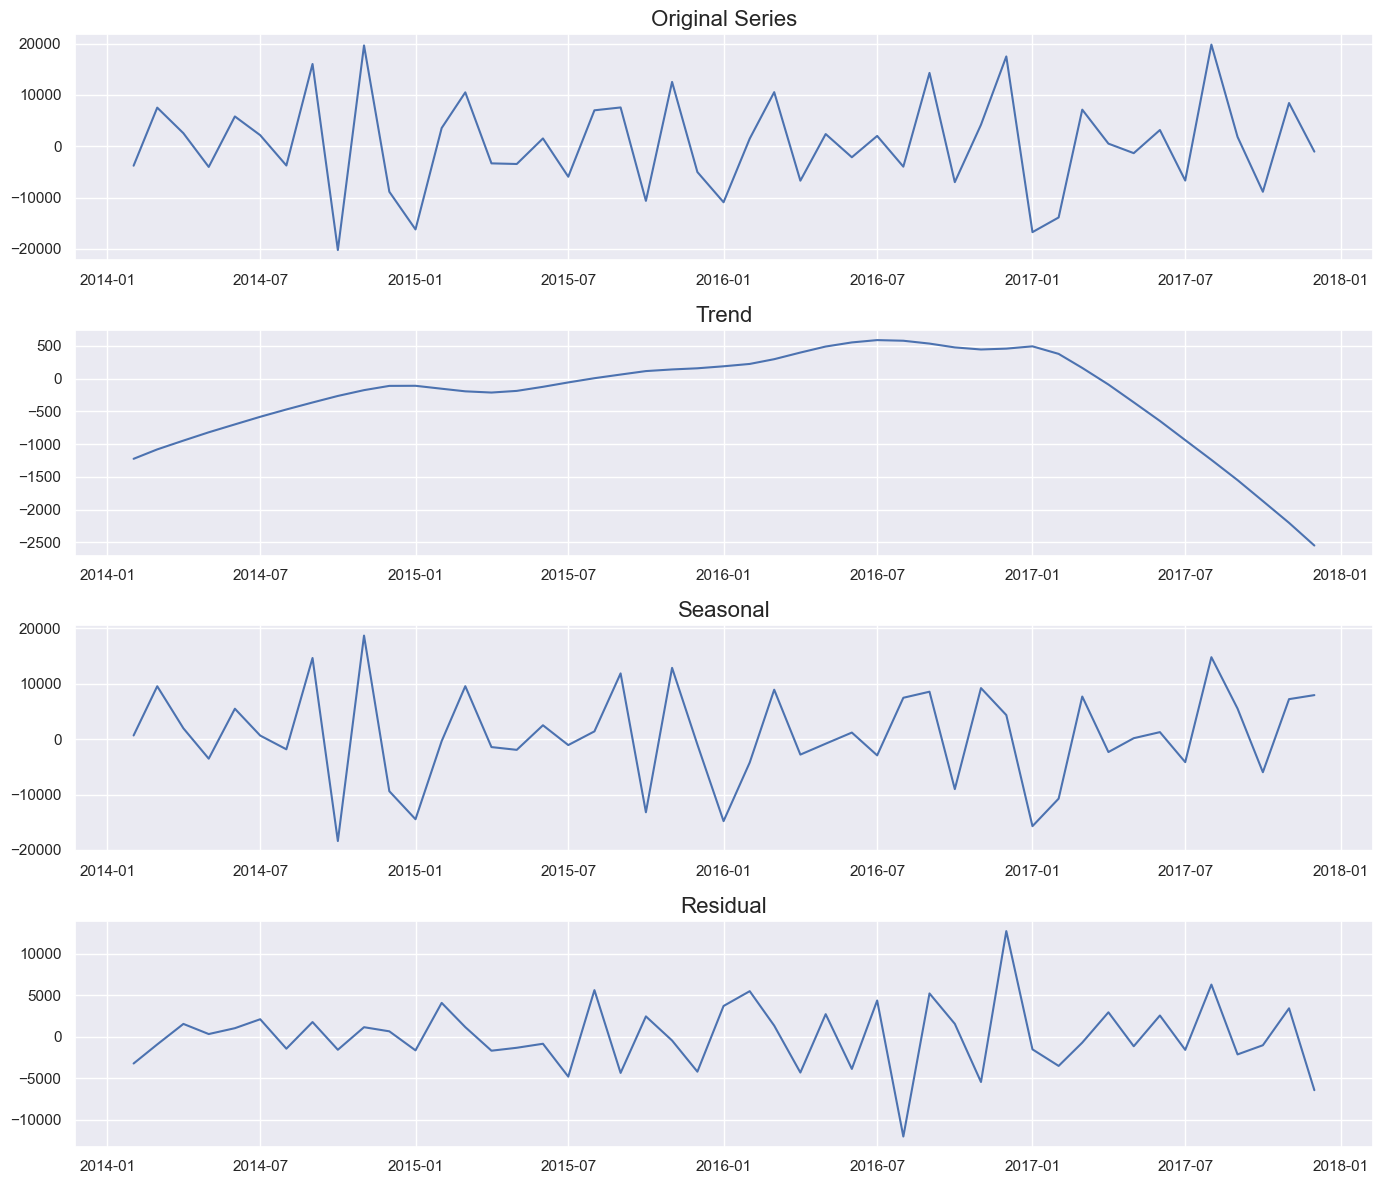

In [47]:
plt.figure(figsize=(14,12))

plt.subplot(4,1,1)
plt.plot(df_new['diff_Sales'])
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

As we can see:
- **Trend**: sales are going down at the end of the observed time.
- **Seasonality**: yes, a pattern is seeable but not too clear.
- **Residuals**: seem good as there is no clear pattern.

**Step 3: ANOMALY detection**

To detect an anomaly, we plot explainable data, which includes trend and seasonal data, versus our true data (has residual). If the residual is huge, that is a sign of an anomaly.

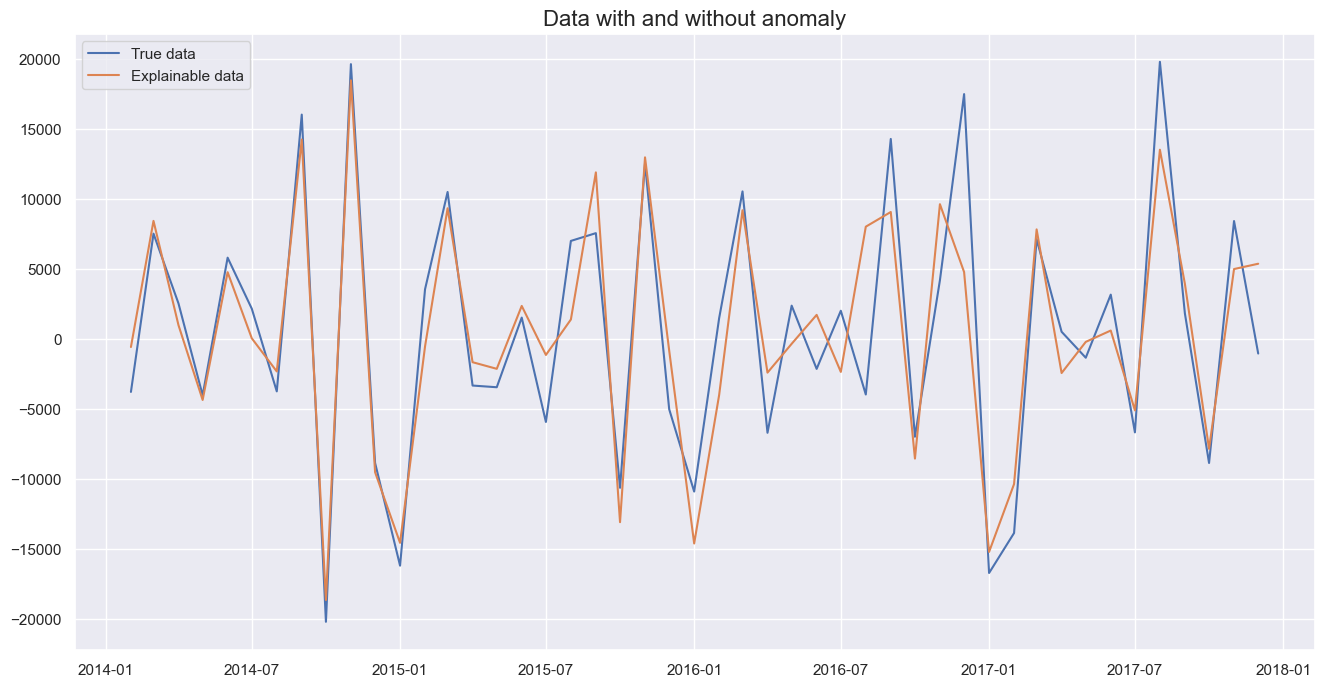

In [262]:
# Explainable data
estimated = trend + seasonal
#
plt.figure(figsize=(16,8))
plt.plot(df_new['diff_Sales'],label='True data')
plt.plot(estimated,label='Explainable data')
plt.legend()
plt.title('Data with and without anomaly', fontsize=16)
plt.show()

To quantify if residuals are creating outliers in our data, we use the dispersion analysis to check the distribution of residuals around the mean. 
Here the threshold is 3 Standard Deviation.

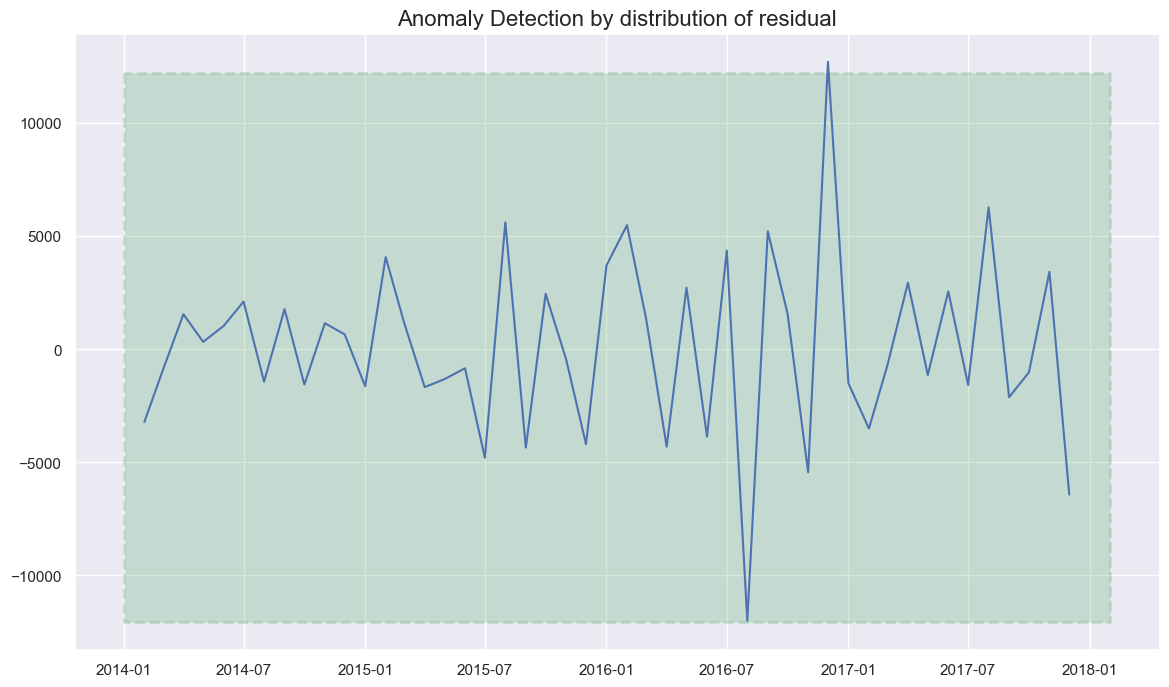

In [49]:
# Calculate mean and sd
resid_mu = resid.mean()
resid_dev = resid.std()
# Assign upper and lower tails (3SD)
lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev
# Plot the data
plt.figure(figsize=(14,8))
plt.plot(resid)
plt.title('Anomaly Detection by distribution of residual', fontsize=16)
# Draw a rectangle to capture normal data 
plt.fill_between([datetime(2014,1,1), datetime(2018,2,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)

As we can see in the plot above, there is a small data point around 12/2016 go beyond the boundary, hence they can be considered anomalies.

In [50]:
# Calculate anomaly
anomalies = df_new[(resid < lower) | (resid > upper)]

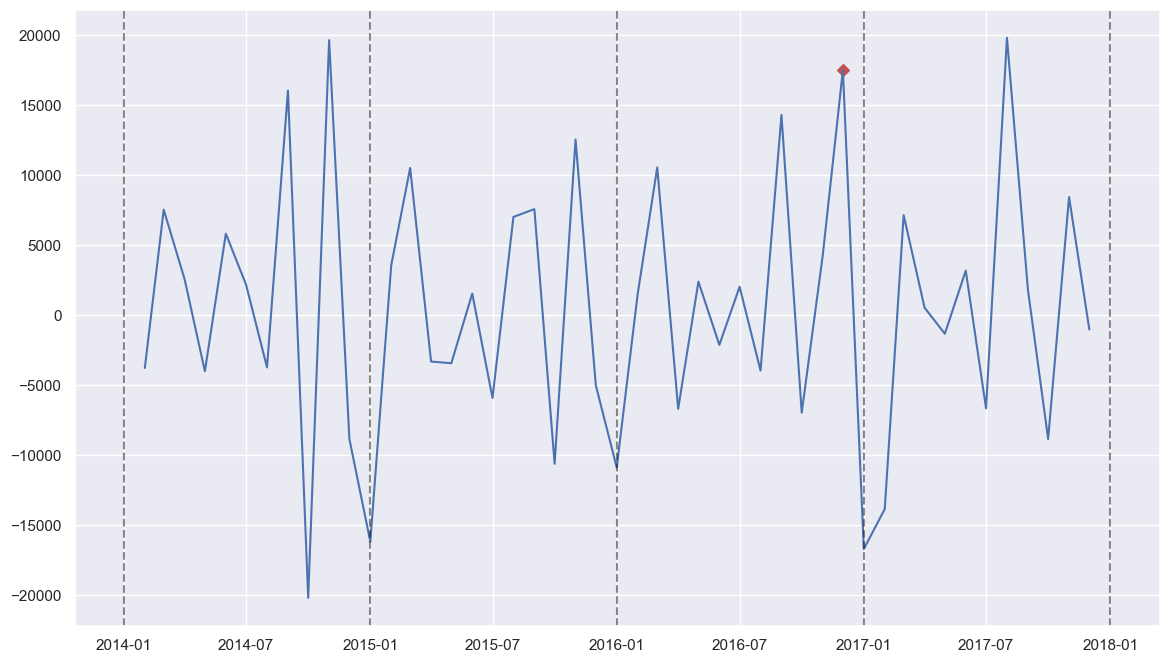

In [51]:
# Plot anomaly
plt.figure(figsize=(14,8))
plt.plot(df_new['diff_Sales'])
for year in range(2014,2019):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.diff_Sales, color='r', marker='D')

In [52]:
# Display anomaly
anomalies

,Sales,diff_Sales
Order Date,,
2016-12-01,37997.566,17510.288


Since the author has no metadata about this order date, the author will keep it in the data without removal. 
Maybe, in December 2016, the company could run a heavy promotion, which led to this surge of sales.

**Step 4: Check WHITE NOISE**

White noise in time series data refers to a random and unpredictable fluctuation in the data. It is a type of noise that has constant variance and no correlation between its values at different points in time. 

One way to check if data has white noise is to look at the pattern of **Residuals**. If there is no pattern, data is white noise, and we dont need to transform further.

Text(0.5, 1.0, 'Residual')

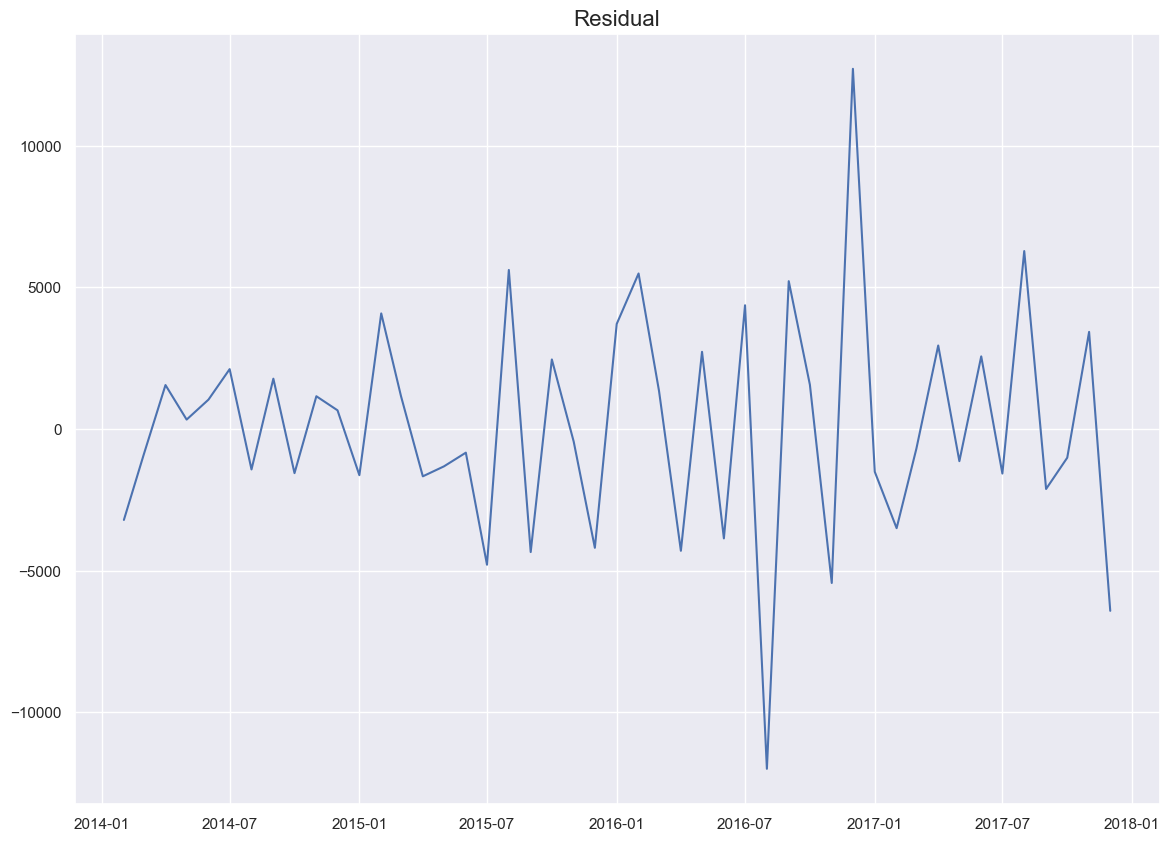

In [267]:
plt.plot(resid)
plt.title('Residual', fontsize=16)

At this point, our data is good as we can see white noise in the residual.

**Step 5: Identify ORDERS of model**

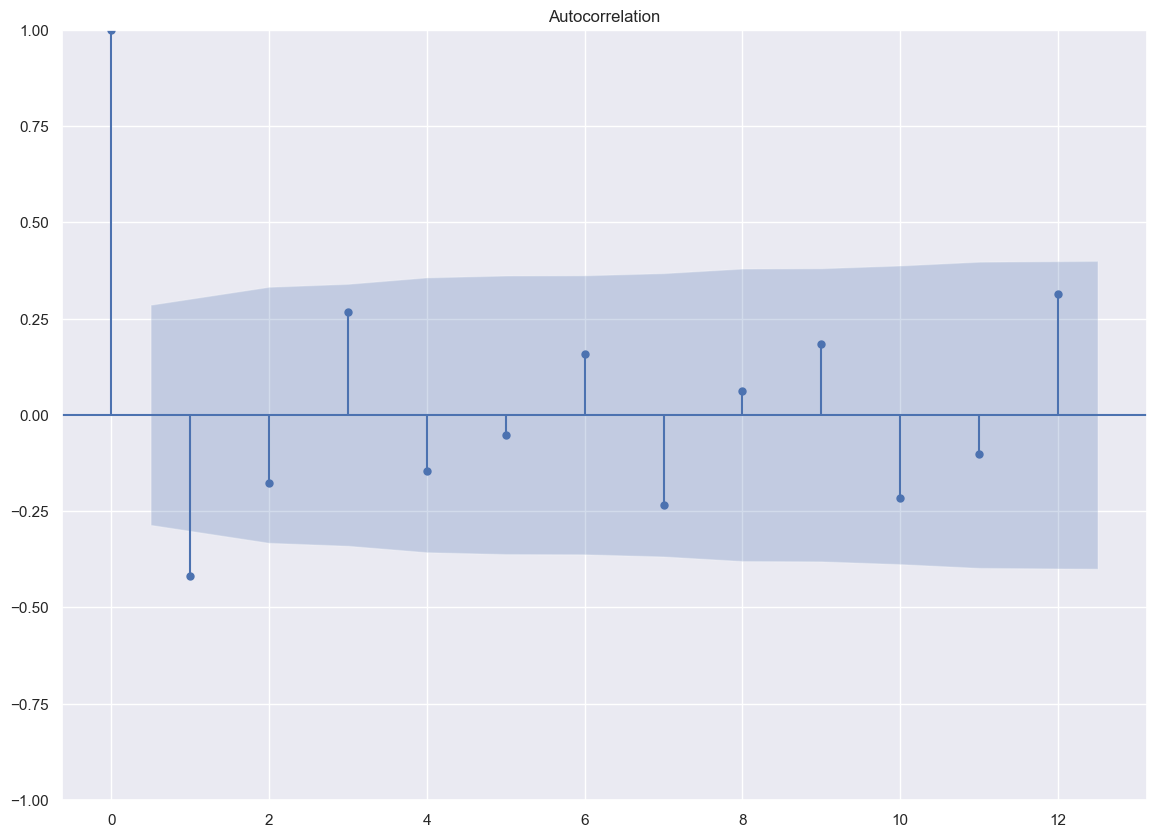

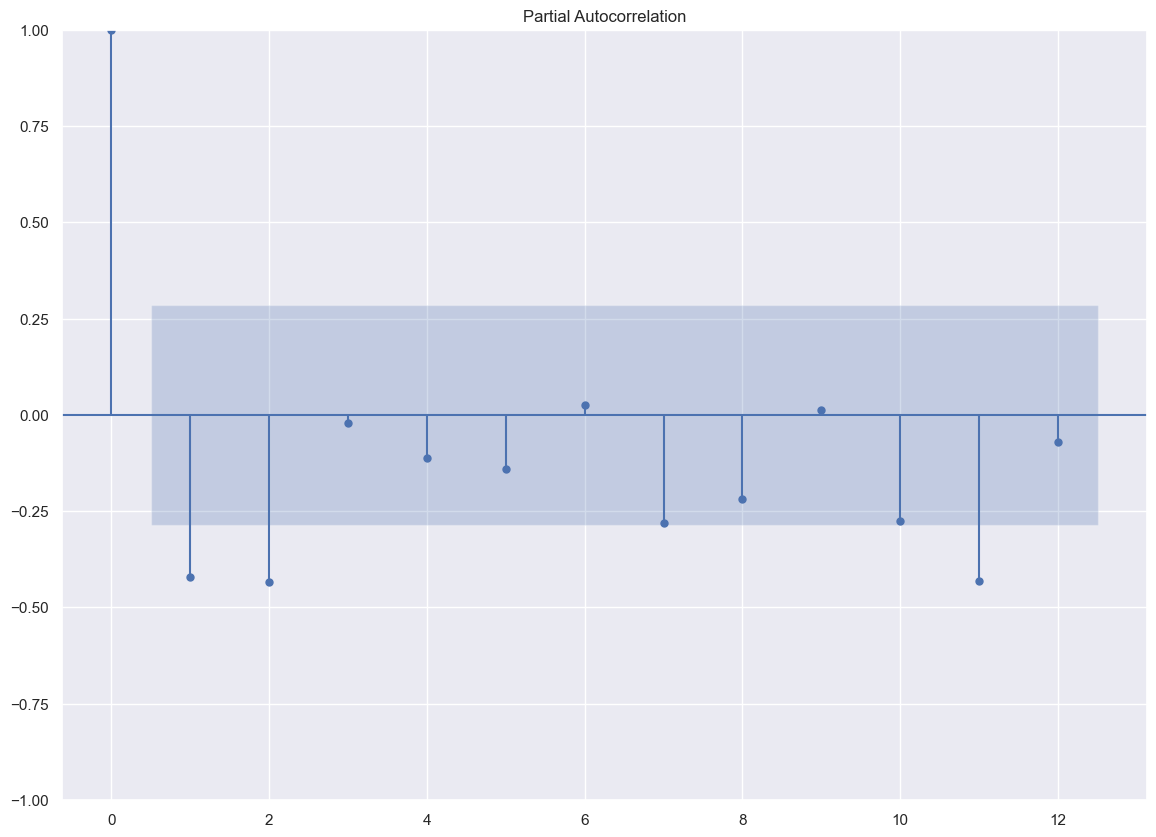

In [268]:
plot_acf(df_new.diff_Sales, lags=12);
plot_pacf(df_new.diff_Sales, lags=12, method = "ols");

To identify the order, we can take a look at both plots and refer to this table to choose the most appropriate values for p and q.

|       | AR(p) | MA(q) | ARMA(p,q) |
|-------|-------|-------|------|
| ACF   | Tails off (Geometric decay) | Significant at lag  𝑞  / Cuts off after lag  𝑞 | Tails off (Geometric decay) |
| PACF  | Significant at each lag  𝑝 / Cuts off after lag  𝑝 | Tails off (Geometric decay) | Tails off (Geometric decay) |

But instead of manually detecting orders by eyes, the author will use grid search to find the best orders which could give us the smallest AIC in this case.
We know that **d = 1** as we need to try different combinations of q and p only.

- Split data

In [53]:
train_end = datetime(2016,12,1) # Forecast sales for last 12 months
test_end = datetime(2018,1,1)

train_data = df_new[:train_end]
test_data = df_new[train_end + timedelta(days=1):test_end]

In [54]:
train_data.head()

,Sales,diff_Sales
Order Date,,
2014-02-01,1071.724,-3779.356
2014-03-01,8605.879,7534.155
2014-04-01,11155.074,2549.195
2014-05-01,7135.624,-4019.450
2014-06-01,12953.037,5817.413


In [55]:
test_data

,Sales,diff_Sales
Order Date,,
2017-01-01,21274.289,-16723.277
2017-02-01,7407.772,-13866.517
2017-03-01,14550.286,7142.514
2017-04-01,15072.191,521.905
2017-05-01,13736.964,-1335.227
2017-06-01,16912.039,3175.075
2017-07-01,10241.468,-6670.571
2017-08-01,30059.852,19818.384
2017-09-01,31895.843,1835.991


- Create a function to show all AIC with different combination of order lists

In [324]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = sm.tsa.ARIMA(exog, order=order).fit()
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

- Test on different combinations, in which only d is fixed at 1.

In [325]:
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)
# Create a list with all possible combination of parameters
parameters = itertools.product(ps,qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d) # insert d in the second position
    each = tuple(each) # convert to tuble
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=train_data['Sales'])
result_df

  0%|          | 0/100 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(2, 1, 0)",7.108876e+02
1,"(0, 1, 1)",7.111792e+02
2,"(0, 1, 2)",7.124042e+02
3,"(1, 1, 1)",7.128363e+02
4,"(3, 1, 0)",7.128879e+02
...,...,...
85,"(8, 1, 7)",1.980385e+13
86,"(6, 1, 7)",1.980385e+13
87,"(9, 1, 7)",1.980385e+13
88,"(7, 1, 7)",1.980385e+13


Our final order would be: 2,1,0

**Step 6: MODELING**

**ARIMA**
- Fit model

In [326]:
best_model = sm.tsa.ARIMA(train_data['Sales'], order=(2,1,0)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   35
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -352.444
Date:                Wed, 19 Apr 2023   AIC                            710.888
Time:                        16:01:13   BIC                            715.467
Sample:                    02-01-2014   HQIC                           712.449
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7021      0.159     -4.428      0.000      -1.013      -0.391
ar.L2         -0.4257      0.157     -2.713      0.007      -0.733      -0.118
sigma2      5.851e+07   4.15e-10   1.41e+17      0.0

- Predict

In [327]:
# Predict 
df_new['ARIMA'] = best_model.predict(start=train_end, end=test_end)

<function matplotlib.pyplot.show(close=None, block=None)>

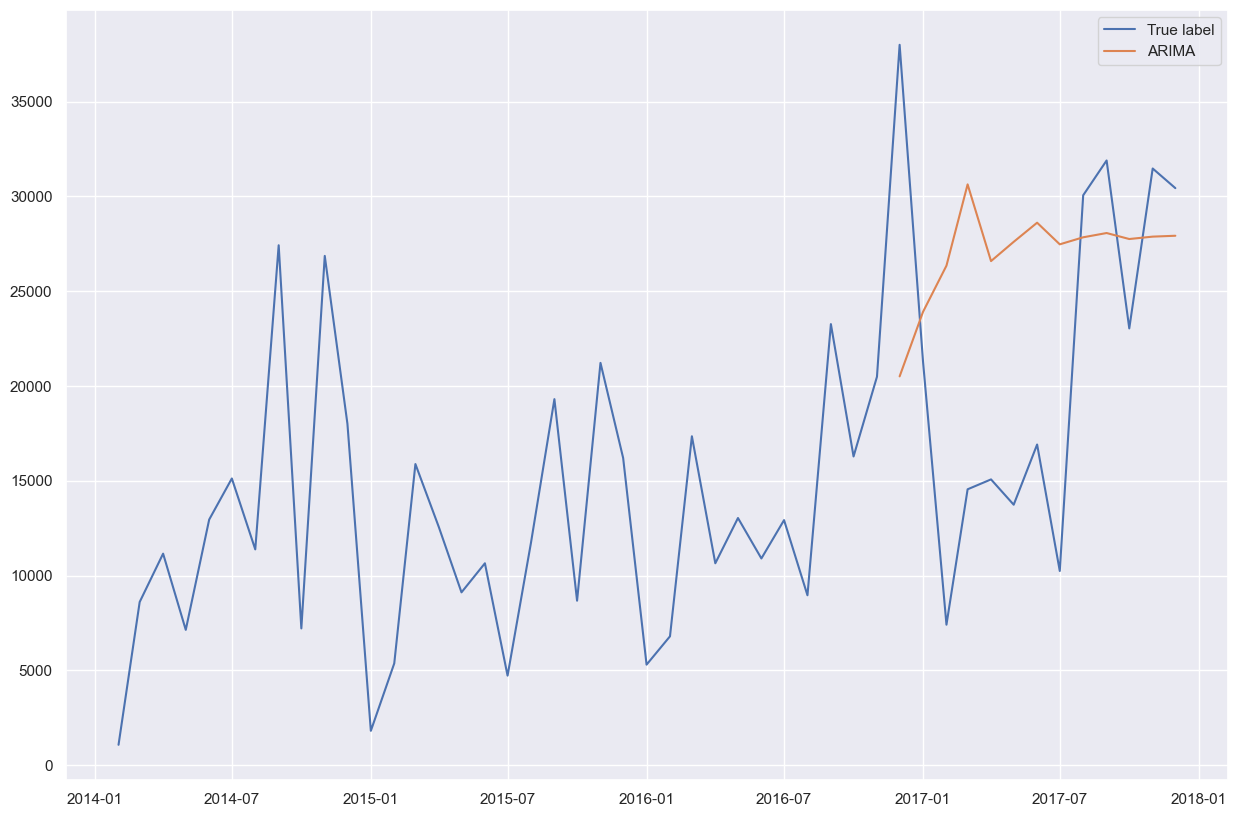

In [328]:
# plot
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df_new['Sales'],label='True label')
plt.plot(df_new['ARIMA'],label='ARIMA')
plt.legend()
plt.show

In [329]:
# Performance
print('Mean Absolute Percent Error for ARIMA:', round(np.mean(abs((df_new.loc[df_new.index>train_end,'Sales']-df_new.loc[df_new.index>train_end,'ARIMA'])/df_new.loc[df_new.index > train_end,'Sales']))*100,4),'%')

Mean Absolute Percent Error for ARIMA: 71.076 %


With the result is so bad, the author will fit an SARIMA model instead, which accounts for the seasonal pattern in data.

**SARIMA**

- Define the orders

In [330]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [331]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = itertools.product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


- Fit to select the optimal ones

In [332]:
result_df2 = optimize_SARIMA(parameters_list, d, D, s, train_data['Sales'])
result_df2

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 0, 3)",622.080040
1,"(0, 3, 0, 2)",623.657803
2,"(1, 2, 2, 1)",623.821249
3,"(2, 1, 2, 2)",624.915942
4,"(1, 2, 2, 0)",625.321610
...,...,...
251,"(1, 1, 0, 0)",650.464299
252,"(0, 0, 2, 3)",651.609051
253,"(0, 0, 1, 0)",654.141368
254,"(1, 0, 0, 0)",654.407490


From the result, we got:
- p = 1
- d = 1
- q = 0
- P = 0
- D = 1
- Q = 3
- S= 4

So let apply these figures to the model.

- Fit the best model

In [333]:
best_SARIMA = SARIMAX(train_data['Sales'],order=(1, 1, 2), seasonal_order=(0, 1, 3, 4)).fit()
print(best_SARIMA.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18958D+00    |proj g|=  3.32558D-01

At iterate    5    f=  8.99341D+00    |proj g|=  9.93035D-03

At iterate   10    f=  8.99124D+00    |proj g|=  9.56778D-04

At iterate   15    f=  8.99122D+00    |proj g|=  2.63728D-04

At iterate   20    f=  8.99122D+00    |proj g|=  5.92674D-05

At iterate   25    f=  8.99112D+00    |proj g|=  2.09435D-03

At iterate   30    f=  8.96847D+00    |proj g|=  3.21916D-02

At iterate   35    f=  8.78184D+00    |proj g|=  6.31783D-02

At iterate   40    f=  8.70385D+00    |proj g|=  8.82237D-03

At iterate   45    f=  8.69630D+00    |proj g|=  1.70028D-02


 This problem is unconstrained.



At iterate   50    f=  8.68686D+00    |proj g|=  3.27952D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   3.280D-04   8.687D+00
  F =   8.6868577163452372     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                         SARIMAX Results                                         
Dep. Variable:                                     Sales   No. Observations:                   35
Model:             SARIMAX(1, 1, 2)x(0, 1, [1, 2, 3], 4)   Log Likelihood                -304.040
Date:                                   Wed, 19 Apr 2023   AIC     

- Predict

In [334]:
# Predict 
df_new['SARIMAX'] = best_SARIMA.predict(start=train_end, end=test_end)

<function matplotlib.pyplot.show(close=None, block=None)>

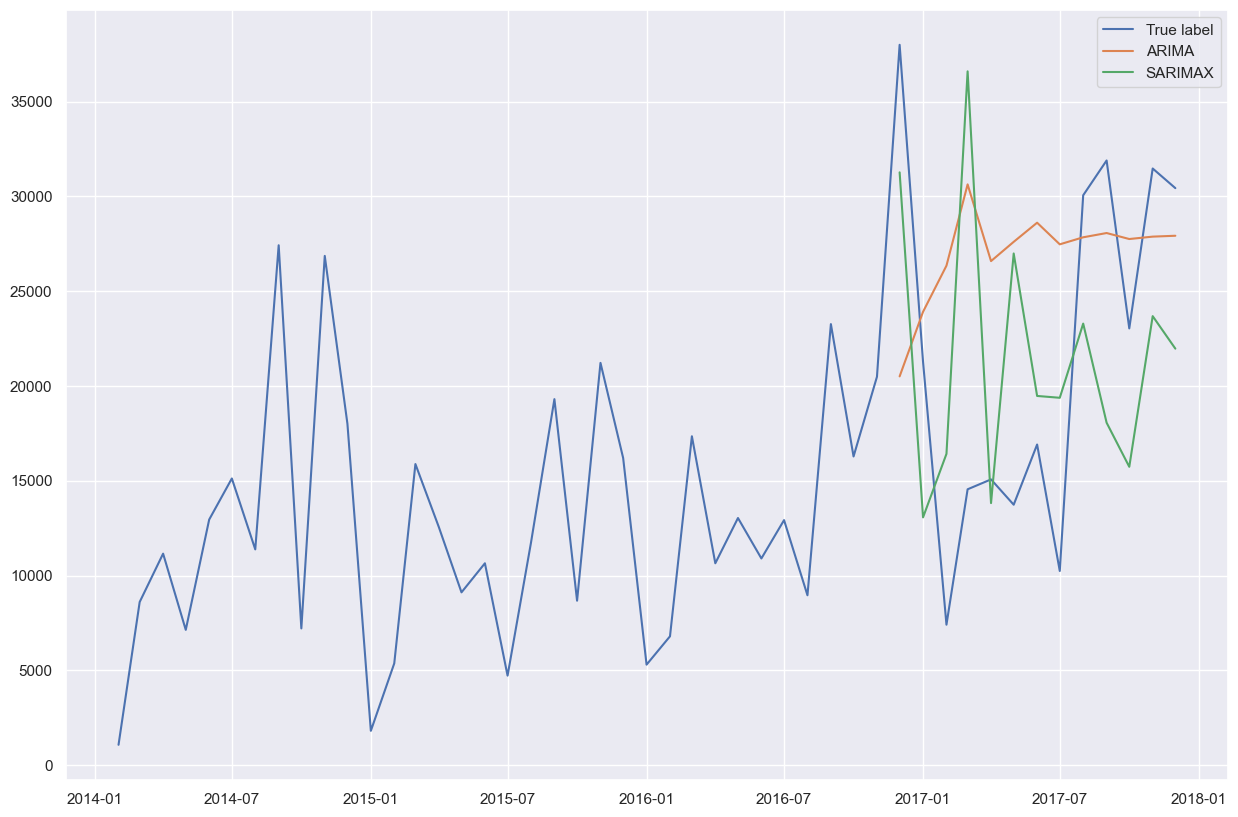

In [335]:
# plot
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df_new['Sales'],label='True label')
plt.plot(df_new['ARIMA'],label='ARIMA')
plt.plot(df_new['SARIMAX'],label='SARIMAX')
plt.legend()
plt.show

In [336]:
# Performance
print('Mean Absolute Percent Error for SARIMAX:', round(np.mean(abs((df_new.loc[df_new.index>train_end,'Sales']-df_new.loc[df_new.index>train_end,'SARIMAX'])/df_new.loc[df_new.index > train_end,'Sales']))*100,4),'%')

Mean Absolute Percent Error for SARIMAX: 55.9179 %


**Final thoughts:**

- The SARIMAX model has demonstrated a significant improvement in accuracy compared to the ARIMA model, as evidenced by the plot.
- Look at the plot, the Green line closely follows the trend of the Blue line, in contrast to the poor performance of the Orange line.
- However, the SARIMAX model did not perform as well as expected due to the presence of outliers in the prediction testing period and the limited training data available (4 years).
- It is important to note that in real-world industry problems, outliers can be identified and addressed, and a longer time series of data can be used for training.

Overall, this work provides insights into the effective use of SARIMAX for sales prediction and I do hope you guys can grab an idea how to handle it to predict data.

In [343]:
# Export all packages to requirement.txt for code reproducibility.
import pkg_resources
import sys

# Get a set of all the installed package names
installed_packages = {d.project_name.lower(): d.version for d in pkg_resources.working_set}

# Get a set of all the imported package names
imported_packages = {pkg.key.lower() for pkg in pkg_resources.working_set if pkg.key in sys.modules}

# Get the set of packages that were imported during your work
used_packages = imported_packages.intersection(installed_packages)

# Print the list of used packages along with their versions
with open('requirements.txt', 'w') as f:
    for package in sorted(used_packages):
        f.write(f"{package}=={installed_packages[package]}\n")
        print(f"{package}=={installed_packages[package]}")


appnope==0.1.2
asttokens==2.0.5
backcall==0.2.0
bottleneck==1.3.5
cffi==1.15.1
colorama==0.4.6
comm==0.1.2
cycler==0.11.0
debugpy==1.5.1
decorator==5.1.1
defusedxml==0.7.1
entrypoints==0.4
executing==0.8.3
ipykernel==6.19.2
ipywidgets==7.6.5
jedi==0.18.1
joblib==1.1.1
kiwisolver==1.4.4
lz4==3.1.3
matplotlib==3.7.0
numexpr==2.8.4
numpy==1.23.5
packaging==22.0
pandas==1.5.3
parso==0.8.3
pathlib==1.0.1
patsy==0.5.3
pexpect==4.8.0
pickleshare==0.7.5
platformdirs==2.5.2
psutil==5.9.0
ptyprocess==0.7.0
pygments==2.11.2
pyparsing==3.0.9
pytz==2022.7
scipy==1.10.0
seaborn==0.12.2
setuptools==65.6.3
six==1.16.0
statsmodels==0.13.5
threadpoolctl==2.2.0
tornado==6.1
tqdm==4.64.1
traitlets==5.7.1
wcwidth==0.2.5
xlrd==2.0.1
